# Week 3 Mini Project: Histopathologic Cancer Detection

**The Data Challenge Source:** https://www.kaggle.com/c/histopathologic-cancer-detection/data  
**My Github Link:** https://github.com/lzheng01/Histopathologic-Cancer-Detection

# 1. Introduction

### The project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. 
### The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

## 1.1 Libraries Installation and Directory Setup

In [1]:
!pip install -q mamba_ssm timm pytorch_lightning

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 29.9 MB/s eta 0:00:00


In [2]:
import requests
url = 'https://raw.githubusercontent.com/YubiaoYue/MedMamba/main/MedMamba.py'
response = requests.get(url)
with open('MedMamba.py', 'wb') as file:
    file.write(response.content)

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import runtime
from google.colab import drive
import os

from PIL import Image
from PIL import ImageDraw
from matplotlib.ticker import FixedLocator

from MedMamba import *
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from tqdm import tqdm


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -u -q "/content/drive/My Drive/CNN/histopathologic-cancer-detection.zip" -d "/content/data"

In [6]:
# Specify file paths
current_dir = os.getcwd()
path_dir = os.path.join(current_dir, 'data/')
train_path = path_dir + 'train/'
labels_path = path_dir + 'train_labels.csv'
sample_solution_path = path_dir + 'sample_submission.csv'
test_path = path_dir + 'test/'

In [7]:
# Import data
sample_solution = pd.read_csv(sample_solution_path)
labels = pd.read_csv(labels_path)
img_train = os.listdir(train_path)
img_test = os.listdir(test_path)

print("Number of training images: {}".format(len(img_train)))
print("Number of test images: {}".format(len(img_test)))

Number of training images: 220025
Number of test images: 57458


This is a large dataset, so we need to utilize more computational power for training the whole dataset.

## 1.2 Exploratory Analysis (EDA)

In [8]:
# Display the first few records of the labels
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
# Display the sample data in the sample submission file
sample_solution.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [10]:
# Check the size of image
im = Image.open(train_path + img_train[0])
width, height = im.size
print("Image size: {} x {}".format(width, height))

Image size: 96 x 96


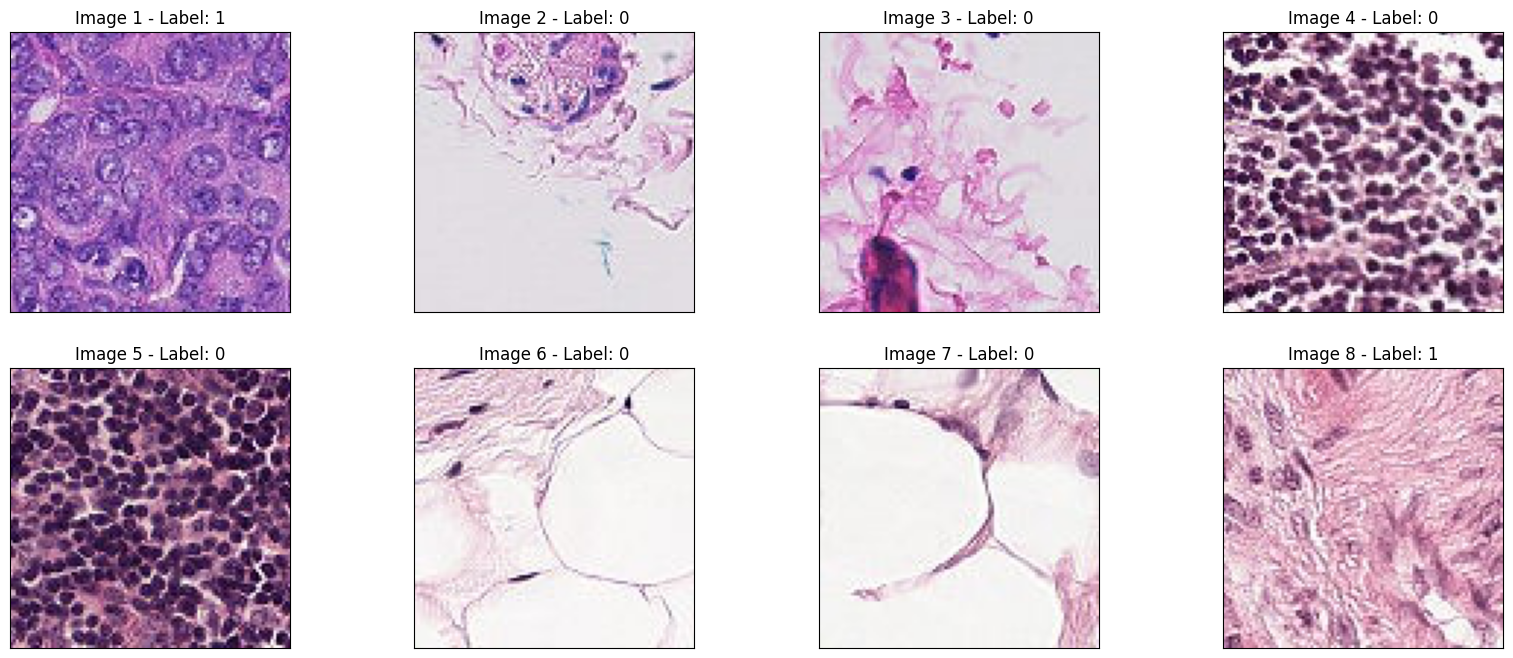

In [11]:
# Display first 8 images from train
fig = plt.figure(figsize=(20, 8))

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    im = Image.open(train_path + img_train[i])
    plt.imshow(im)
    label = labels.loc[labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'Image {i+1} - Label: {label}')

In [12]:
# Check for missing values and duplicates
missing_values = labels.isnull().sum()[1]
print(f'{missing_values} missing values in labels')
duplicated_rows = labels.duplicated().sum()
print(f'{duplicated_rows} duplicated rows in labels')

0 missing values in labels
0 duplicated rows in labels


In [13]:
# Show how many 0 and 1 in the labels
labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

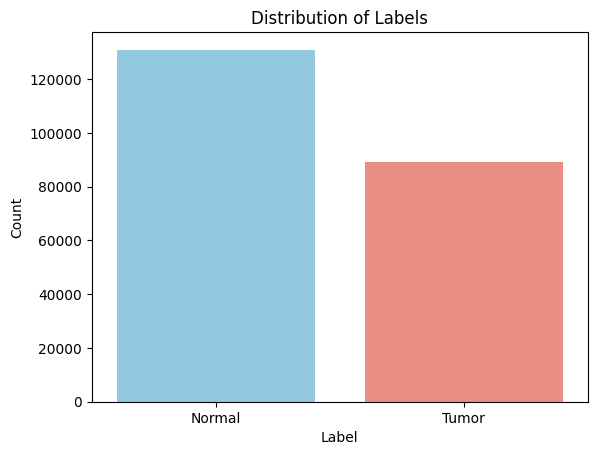

In [14]:
# Plot 0 as normal and 1 as tumor
ax = sns.countplot(x='label', hue='label', data=labels, palette=['skyblue', 'salmon'], legend=False)
ax.set_title('Distribution of Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.xaxis.set_major_locator(FixedLocator([0, 1]))
ax.set_xticklabels(['Normal', 'Tumor'])
plt.show()

From the training set, we could see that there is more Normal cases than Tumor cases. But it is relatively balanced in this dataset.

-------
# 2. Model Architecture
-----



## 2.1 MedMamba

MedMamba is a specialized variant of the Mamba architecture designed for medical image classification. Developed to address the unique challenges in medical imaging, MedMamba combines the local feature extraction capabilities of convolutional layers with the long-range dependency modeling of State Space Models (SSMs).

This architecture is suited with this case for medical image classfication.

### Below is the pytorch lightning implementation of the MedMamba

In [15]:
# CustomDataset is a subclass of Dataset designed to load and preprocess images for training and validation.
class CustomDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        """
        Initialize the dataset with the directory containing images, a DataFrame with labels, and optional transformations.

        Parameters:
        - img_dir (str): Directory containing the image files.
        - labels (pd.DataFrame): DataFrame containing image filenames and corresponding labels.
        - transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.
        """
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve the image and label corresponding to the given index.

        Parameters:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - image (Tensor): Transformed image tensor.
        - label (int): Label corresponding to the image.
        - filename (str): Filename of the image without the extension.
        """
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0] + '.tif')
        if not os.path.isfile(img_name):
            raise FileNotFoundError(f"File {img_name} not found.")
        image = Image.open(img_name).convert("RGB")
        label = self.labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label, self.labels.iloc[idx, 0]  # Return filename instead of img_name

# MedMambaClassifier is a PyTorch Lightning Module for training and evaluating the VSSM model.
class MedMambaClassifier(pl.LightningModule):
    def __init__(self, train_path, labels_path, log_path='training_log.csv', batch_size=64, epochs=10, num_workers=0,patch_size=4, in_chans=3, num_classes=2, d_state=16, lr=1e-4, eps=1e-8, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1):
        """
        Initialize the classifier with training parameters and data paths.

        Parameters:
        - train_path (str): Path to the training images directory.
        - labels_path (str): Path to the CSV file containing image labels.
        - log_path (str): Path to save the training log.
        - batch_size (int): Number of samples per batch.
        - epochs (int): Number of epochs to train.
        - patch_size, in_chans, num_classes, d_state, drop_rate, attn_drop_rate, drop_path_rate: Model-specific hyperparameters.
        - lr (float): Learning rate.
        - eps (float): Term added to the denominator to improve numerical stability in Adam optimizer.
        """
        super(MedMambaClassifier, self).__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.epochs = epochs
        self.log_path = log_path
        self.num_workers = num_workers
        self.train_log = []

        # Image transformation: resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([
            transforms.Resize((96, 96)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load and split data into training and validation sets
        self.train_labels = pd.read_csv(labels_path)
        self.img_train = os.listdir(train_path)
        train_labels, val_labels = train_test_split(self.train_labels, test_size=0.2, random_state=42, stratify=self.train_labels['label'])
        self.train_dataset = CustomDataset(train_path, train_labels, transform=self.transform)
        self.val_dataset = CustomDataset(train_path, val_labels, transform=self.transform)

        # Initialize the VSSM model with specified parameters
        self.model = VSSM(
            patch_size=patch_size,
            in_chans=in_chans,
            num_classes=num_classes,
            d_state=d_state,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate
        )

    def forward(self, x):
        """
        Perform a forward pass through the model.

        Parameters:
        - x (Tensor): Input image tensor.

        Returns:
        - Tensor: Model output.
        """
        return self.model(x)

    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
        - optimizer (torch.optim.Optimizer): AdamW optimizer.
        """
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.hparams.lr, eps=self.hparams.eps)
        return optimizer

    def training_step(self, batch, batch_idx):
        """
        Perform a single training step.

        Parameters:
        - batch (tuple): Batch of training data (images, labels, filenames).
        - batch_idx (int): Index of the batch.

        Returns:
        - loss (Tensor): Training loss.
        """
        images, labels, _ = batch
        outputs = self.model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Perform a single validation step.

        Parameters:
        - batch (tuple): Batch of validation data (images, labels, filenames).
        - batch_idx (int): Index of the batch.

        Returns:
        - loss (Tensor): Validation loss.
        """
        images, labels, _ = batch
        outputs = self.model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        """
        Log training and validation metrics at the end of each epoch and save to a CSV file.
        """
        avg_train_loss = self.trainer.callback_metrics['train_loss'].item()
        avg_train_accuracy = self.trainer.callback_metrics['train_accuracy'].item()
        avg_val_loss = self.trainer.callback_metrics['val_loss'].item()
        avg_val_accuracy = self.trainer.callback_metrics['val_accuracy'].item()
        epoch = self.current_epoch

        # Append to the log
        self.train_log.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': avg_train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': avg_val_accuracy
        })

        # Save the log to a CSV file
        pd.DataFrame(self.train_log).to_csv(self.log_path, index=False, mode='w')

    def train_dataloader(self):
        """
        Create the DataLoader for training data.

        Returns:
        - DataLoader: DataLoader for training data.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        """
        Create the DataLoader for validation data.

        Returns:
        - DataLoader: DataLoader for validation data.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def predict_dataloader(self, test_data_dir):
        """
        Create the DataLoader for test data.

        Parameters:
        - test_data_dir (str): Directory containing the test images.

        Returns:
        - DataLoader: DataLoader for test data.
        """
        img_test = os.listdir(test_data_dir)
        img_test = [os.path.splitext(f)[0] for f in img_test if f.endswith('.tif')]
        test_labels = pd.DataFrame({'filename': img_test, 'label': -1})
        test_dataset = CustomDataset(test_data_dir, test_labels, transform=self.transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def predict_step(self, batch, batch_idx):
        """
        Perform a single prediction step.

        Parameters:
        - batch (tuple): Batch of test data (images, labels, filenames).
        - batch_idx (int): Index of the batch.

        Returns:
        - dict: Dictionary containing predictions and filenames.
        """
        images, _, filenames = batch
        outputs = self.model(images)
        _, predicted = torch.max(outputs, 1)
        return {'predictions': predicted.cpu().numpy(), 'filenames': filenames}

    def predict(self, test_data_dir):
        """
        Predict the labels for the test data.

        Parameters:
        - test_data_dir (str): Directory containing the test images.

        Returns:
        - predictions_df (pd.DataFrame): DataFrame containing image IDs and predicted labels.
        """
        test_loader = self.predict_dataloader(test_data_dir)
        trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
        predictions = trainer.predict(self, test_loader)

        image_ids = []
        for batch in test_loader:
            image_ids.extend([os.path.splitext(path)[0] for path in batch[2]])

        predictions = [pred['predictions'] for pred in predictions]
        predictions = [item for sublist in predictions for item in sublist]

        predictions_df = pd.DataFrame({
            'id': image_ids,
            'label': predictions
        })
        return predictions_df


In [16]:
mamba_log = '/content/drive/My Drive/CNN/mamba_training_log.csv'
mamba = MedMambaClassifier(train_path, labels_path, log_path=mamba_log, batch_size=256, epochs=20, num_workers=11)

trainer = Trainer(max_epochs=mamba.epochs, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
trainer.fit(mamba)

mamba_predictions_df = mamba.predict(test_path)

print(mamba_predictions_df.head())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | VSSM | 14.5 M
-------------------------------
14.5 M    Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 229. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

                                         id  label
0  00cca1c4e98f0413c301f4896209412ee70de13b      1
1  fb67b3458082658d14b60d965db2f3910c2ca849      0
2  40858dba9bd6e25fed3be80e66aaebaba56c4fd1      1
3  141b8702bb87d6cb34b3110d87c7f2818ce2ba9d      0
4  e9a21579395a26b92ba49e0b0ef7ffbcb2461c49      0


In [17]:
mamba_predictions_df.to_csv('/content/drive/My Drive/CNN/submission2.csv', index=False)

## 2.2 ResNet50

ResNet-50 is a deep convolutional neural network architecture that is part of the Residual Network (ResNet) family, introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in 2015. The primary innovation of ResNet is the use of residual learning to address the vanishing gradient problem, which often hampers the training of very deep networks.

It is a 50-layer deep neural network. It is built by stacking multiple residual blocks, where each block contains a set of convolutional layers and a shortcut connection that bypasses one or more layers. Due to its robust feature extraction capabilities, it is commonly used for classifying images into various categories that adapted for tasks like disease diagnosis and analysis of medical images.

ResNet-50 has become a fundamental model in the deep learning community, known for its efficiency and effectiveness in handling complex visual tasks. So, in this project, this architecture is a golden standard to evaluate the performance of MedMamba.

In [18]:
# ResNetClassifier is a PyTorch Lightning Module for training and evaluating the ResNet model.
class ResNetClassifier(pl.LightningModule):
    def __init__(self, train_path, labels_path, log_path='training_log.csv', batch_size=64, epochs=20, lr=1e-4, num_workers=0):
        """
        Initialize the classifier with training parameters and data paths.

        Parameters:
        - train_path (str): Path to the training images directory.
        - labels_path (str): Path to the CSV file containing image labels.
        - log_path (str): Path to save the training log.
        - batch_size (int): Number of samples per batch.
        - epochs (int): Number of epochs to train.
        - lr (float): Learning rate.
        """
        super(ResNetClassifier, self).__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.epochs = epochs
        self.log_path = log_path
        self.num_workers = num_workers
        self.train_log = []

        # Image transformation: resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([
            transforms.Resize((96, 96)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load and split data into training and validation sets
        self.train_labels = pd.read_csv(labels_path)
        self.img_train = os.listdir(train_path)
        train_labels, val_labels = train_test_split(self.train_labels, test_size=0.2, random_state=42, stratify=self.train_labels['label'])
        self.train_dataset = CustomDataset(train_path, train_labels, transform=self.transform)
        self.val_dataset = CustomDataset(train_path, val_labels, transform=self.transform)

        # Initialize the ResNet50 model with a modified final layer for binary classification
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, 2)

    def forward(self, x):
        """
        Perform a forward pass through the model.

        Parameters:
        - x (Tensor): Input image tensor.

        Returns:
        - Tensor: Model output.
        """
        return self.model(x)

    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
        - optimizer (torch.optim.Optimizer): Adam optimizer.
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        """
        Perform a single training step.

        Parameters:
        - batch (tuple): Batch of training data (images, labels, filenames).
        - batch_idx (int): Index of the batch.

        Returns:
        - loss (Tensor): Training loss.
        """
        images, labels, _ = batch
        outputs = self.model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Perform a single validation step.

        Parameters:
        - batch (tuple): Batch of validation data (images, labels, filenames).
        - batch_idx (int): Index of the batch.

        Returns:
        - loss (Tensor): Validation loss.
        """
        images, labels, _ = batch
        outputs = self.model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        """
        Log training and validation metrics at the end of each epoch and save to a CSV file.
        """
        avg_train_loss = self.trainer.callback_metrics['train_loss'].item()
        avg_train_accuracy = self.trainer.callback_metrics['train_accuracy'].item()
        avg_val_loss = self.trainer.callback_metrics['val_loss'].item()
        avg_val_accuracy = self.trainer.callback_metrics['val_accuracy'].item()
        epoch = self.current_epoch

        # Append to the log
        self.train_log.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': avg_train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': avg_val_accuracy
        })

        # Save the log to a CSV file
        pd.DataFrame(self.train_log).to_csv(self.log_path, index=False, mode='w')

    def train_dataloader(self):
        """
        Create the DataLoader for training data.

        Returns:
        - DataLoader: DataLoader for training data.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        """
        Create the DataLoader for validation data.

        Returns:
        - DataLoader: DataLoader for validation data.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def predict_dataloader(self, test_data_dir):
        """
        Create the DataLoader for test data.

        Parameters:
        - test_data_dir (str): Directory containing the test images.

        Returns:
        - DataLoader: DataLoader for test data.
        """
        img_test = os.listdir(test_data_dir)
        img_test = [os.path.splitext(f)[0] for f in img_test if f.endswith('.tif')]
        test_labels = pd.DataFrame({'filename': img_test, 'label': -1})
        test_dataset = CustomDataset(test_data_dir, test_labels, transform=self.transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def predict_step(self, batch, batch_idx):
        """
        Perform a single prediction step.

        Parameters:
        - batch (tuple): Batch of test data (images, labels, filenames).
        - batch_idx (int): Index of the batch.

        Returns:
        - dict: Dictionary containing predictions and filenames.
        """
        images, _, filenames = batch
        outputs = self.model(images)
        _, predicted = torch.max(outputs, 1)
        return {'predictions': predicted.cpu().numpy(), 'filenames': filenames}

    def predict(self, test_data_dir):
        """
        Predict the labels for the test data.

        Parameters:
        - test_data_dir (str): Directory containing the test images.

        Returns:
        - predictions_df (pd.DataFrame): DataFrame containing image IDs and predicted labels.
        """
        test_loader = self.predict_dataloader(test_data_dir)
        trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
        predictions = trainer.predict(self, test_loader)

        image_ids = []
        for batch in test_loader:
            image_ids.extend([os.path.splitext(path)[0] for path in batch[2]])

        predictions = [pred['predictions'] for pred in predictions]
        predictions = [item for sublist in predictions for item in sublist]

        predictions_df = pd.DataFrame({
            'id': image_ids,
            'label': predictions
        })
        return predictions_df


In [19]:
resnet_log = '/content/drive/My Drive/CNN/resnet_training_log.csv'
resnet = ResNetClassifier(train_path, labels_path, log_path=resnet_log, epochs=20, batch_size=256, num_workers=11)

# Define a Trainer and fit the model
trainer = Trainer(max_epochs=resnet.epochs, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
trainer.fit(resnet)

# Predict using the trained model
resnet_predictions_df = resnet.predict(test_path)

print(resnet_predictions_df.head())

# Save the predictions to a CSV file
resnet_predictions_df.to_csv('/content/drive/My Drive/CNN/submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.uti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

                                         id  label
0  00cca1c4e98f0413c301f4896209412ee70de13b      0
1  fb67b3458082658d14b60d965db2f3910c2ca849      1
2  40858dba9bd6e25fed3be80e66aaebaba56c4fd1      1
3  141b8702bb87d6cb34b3110d87c7f2818ce2ba9d      0
4  e9a21579395a26b92ba49e0b0ef7ffbcb2461c49      0


______
# 3. Results and Analysis
______



## 3.1 Training Log Analysis

In [20]:
mamba_log_df = pd.read_csv(mamba_log)
resnet_log_df = pd.read_csv(resnet_log)

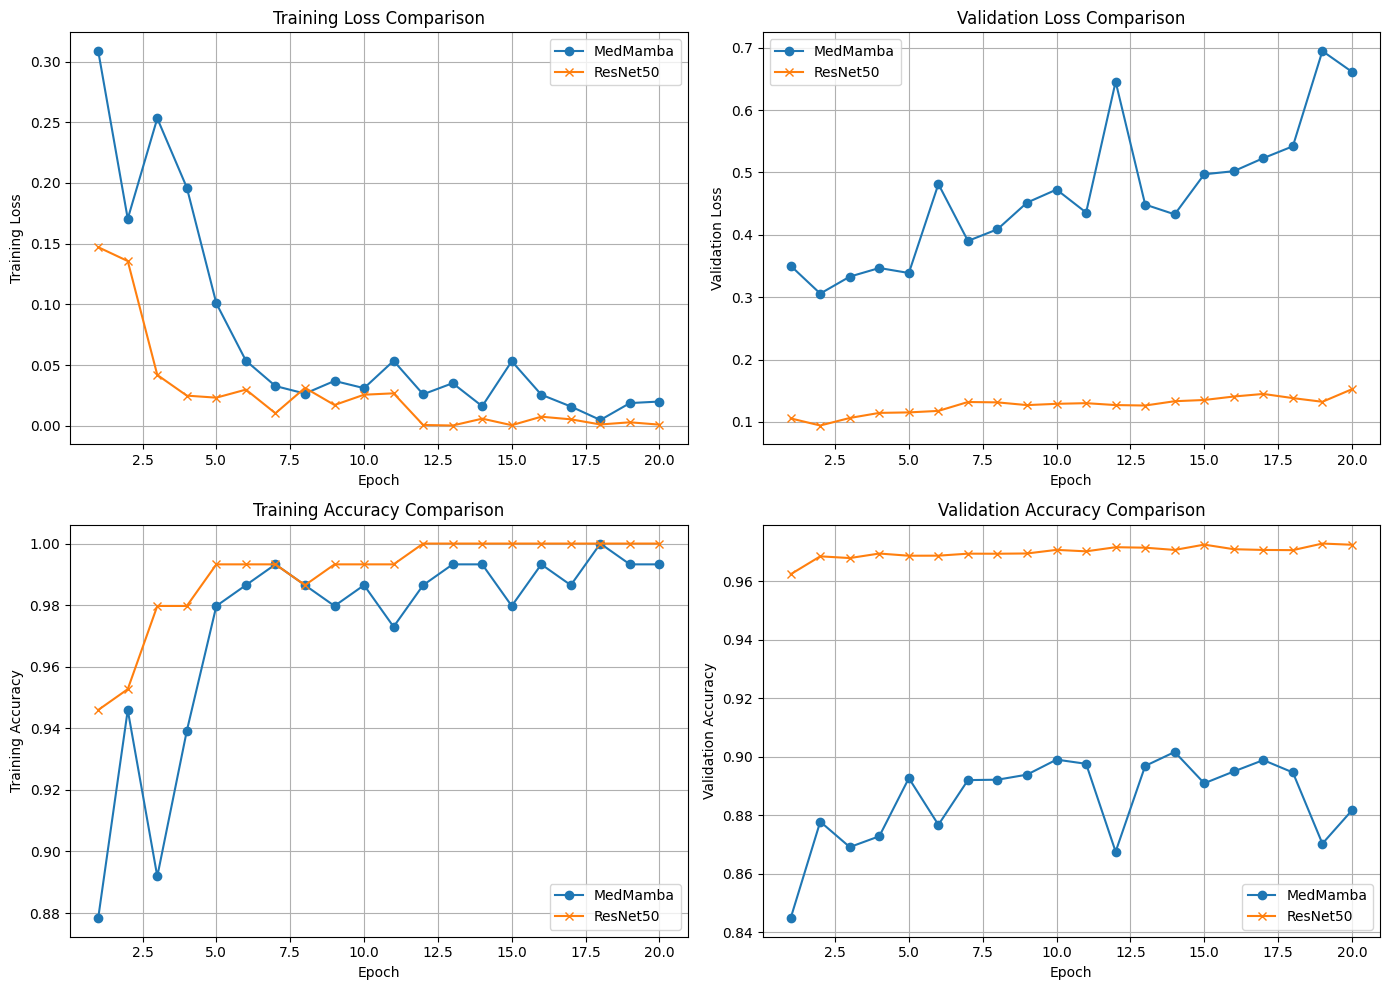

In [21]:
# Create plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].plot(mamba_log_df['epoch'], mamba_log_df['train_loss'], label='MedMamba', marker='o')
ax[0, 0].plot(resnet_log_df['epoch'], resnet_log_df['train_loss'], label='ResNet50', marker='x')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Training Loss')
ax[0, 0].set_title('Training Loss Comparison')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(mamba_log_df['epoch'], mamba_log_df['val_loss'], label='MedMamba', marker='o')
ax[0, 1].plot(resnet_log_df['epoch'], resnet_log_df['val_loss'], label='ResNet50', marker='x')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Validation Loss')
ax[0, 1].set_title('Validation Loss Comparison')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(mamba_log_df['epoch'], mamba_log_df['train_accuracy'], label='MedMamba', marker='o')
ax[1, 0].plot(resnet_log_df['epoch'], resnet_log_df['train_accuracy'], label='ResNet50', marker='x')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Training Accuracy')
ax[1, 0].set_title('Training Accuracy Comparison')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(mamba_log_df['epoch'], mamba_log_df['val_accuracy'], label='MedMamba', marker='o')
ax[1, 1].plot(resnet_log_df['epoch'], resnet_log_df['val_accuracy'], label='ResNet50', marker='x')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Validation Accuracy')
ax[1, 1].set_title('Validation Accuracy Comparison')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

We can see that MedMamba does not perform well after several epochs, and ResNet 50 has much better performance when deal with this dataset.

## 3.2 Kaggle Submission Result

|Models                                  | Private Score | Public Score |
|---------------------------------------------------------------|---------------|--------------|
| ResNet50 20 epochs | 0.8110        | 0.8699       |
| MedMamba 20 epochs  | 0.7554        | 0.8010       |

As we can see in this table, ResNet50 performs better than MedMamba at higher epochs.
For the first epoch, MedMamba performs better and reach a very high score.

______
# 4. Conclusions
______



## 4.1 MedMamba
MedMamba's specialized design for medical image analysis includes mechanisms that excel in multi-class classification or tasks requiring detailed attention to specific regions within an image. However, it is important to note that MedMamba is a newly developed model introduced in 2024 and currently lacks extensive pre-trained weights on large-scale datasets. This absence of comprehensive pre-training might also contribute to its lower performance in binary classification tasks.

## 4.2 ResNet50
ResNet50 demonstrates superior performance at higher epochs, underscoring the advantages of using pre-trained weights for image classification tasks. These pre-trained weights allow ResNet50 to quickly converge and maintain robust performance over multiple epochs. Its general-purpose design, combined with a well-established architecture, makes it particularly effective for binary classification, where it consistently delivers reliable results. The ability of ResNet50 to leverage extensive pre-training on diverse datasets provides it with a significant head start in fine-tuning for specific tasks. 

### In summary, while MedMamba shows initial potential, particularly in early epochs, ResNet50's proven architecture and extensive pre-training give it a distinct advantage in achieving higher accuracy and faster convergence.
